##### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [4]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.keys())

['/us_equities/stocks', '/stooq/us/nyse/stocks/prices', '/stooq/us/nyse/stocks/tickers', '/stooq/us/nyse/etfs/prices', '/stooq/us/nyse/etfs/tickers', '/stooq/us/nasdaq/stocks/prices', '/stooq/us/nasdaq/stocks/tickers', '/stooq/us/nasdaq/etfs/prices', '/stooq/us/nasdaq/etfs/tickers', '/sp500/fred_price', '/sp500/stocks_name']


In [6]:
with pd.HDFStore(DATA_STORE) as store:
    nyse_stocks = store['/stooq/us/nyse/stocks/prices']
    nasdaq_stocks = store['/stooq/us/nasdaq/stocks/prices']
    metadata = store['us_equities/stocks'].loc[:, ['market cap', 'sector']]

In [7]:
# Concatenate the two DataFrames
data = pd.concat([nyse_stocks, nasdaq_stocks])

# Drop NaN values and duplicates
data = data.dropna().drop_duplicates()

# Display the cleaned DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17099280 entries, ('', Timestamp('2005-02-25 00:00:00')) to ('ZYXI', Timestamp('2023-08-11 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 718.0+ MB
None


In [8]:
metadata.sector = pd.factorize(metadata.sector)[0]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, AACG to ZWS
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   market cap  7078 non-null   float64
 1   sector      7516 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 176.2+ KB


In [9]:
metadata

,market cap,sector
ticker,,
AACG,4.079576e+07,0
AACI,0.000000e+00,1
AACIW,0.000000e+00,1
AADI,1.449124e+08,2
AAL,1.022514e+10,0
...,...,...
ZTR,0.000000e+00,1
ZTS,8.818486e+10,2
ZUO,1.433740e+09,3


In [10]:
data = data.join(metadata).dropna(subset=['sector'])


In [11]:
data

open     high      low    close        volume  \
ticker date                                                           
A      2000-01-03  51.1617  51.2803  43.7725  46.7721  5.146705e+06   
       2000-01-04  44.2559  44.7482  42.0636  43.2025  5.246602e+06   
       2000-01-05  43.0401  43.2025  39.1797  40.5250  6.340559e+06   
       2000-01-06  40.0327  40.2818  37.7567  38.9753  2.790543e+06   
       2000-01-07  38.3705  42.8379  38.3287  42.2270  3.104551e+06   
...                    ...      ...      ...      ...           ...   
ZYXI   2023-08-07   8.3600   8.5500   8.0100   8.0300  2.283610e+05   
       2023-08-08   8.0100   8.0200   7.6900   7.7600  3.730130e+05   
       2023-08-09   7.7800   8.0900   7.6300   7.6900  2.705230e+05   
       2023-08-10   7.7300   8.0600   7.7300   7.8200  3.029630e+05   
       2023-08-11   7.8600   7.9200   7.7300   7.7600  2.421330e+05   

                     market cap  sector  
ticker date                              
A      2000-01-03  3.747137e+10     4.0  
       2000-01-04  3.747137e+10     4.0  
       2000-01-05  3.747137e+10     4.0  
       2000-01-06  3.747137e+10     4.0  
       2000-01-07  3.747137e+10     4.0  
...                         ...     ...  
ZYXI   2023-08-07  2.787821e+08     2.0  
       2023-08-08  2.787821e+08     2.0  
       2023-08-09  2.787821e+08     2.0  
       2023-08-10  2.787821e+08     2.0  
       2023-08-11  2.787821e+08     2.0  

[15936158 rows x 7 columns]

In [12]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 6,700 | # Dates: 5,940


In [13]:
# Identifying duplicate entries based on index
duplicates = data[data.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [open, high, low, close, volume, market cap, sector]
Index: []


##### Select 500 most-traded stocks

In [14]:
data.volume

ticker  date      
A       2000-01-03    5.146705e+06
        2000-01-04    5.246602e+06
        2000-01-05    6.340559e+06
        2000-01-06    2.790543e+06
        2000-01-07    3.104551e+06
                          ...     
ZYXI    2023-08-07    2.283610e+05
        2023-08-08    3.730130e+05
        2023-08-09    2.705230e+05
        2023-08-10    3.029630e+05
        2023-08-11    2.421330e+05
Name: volume, Length: 15936158, dtype: float64

In [15]:
dv = data.close.mul(data.volume)
dv = dv[~dv.index.duplicated(keep='first')]

In [16]:
top500 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))

In [17]:
top500

ticker
MSFT       6.012037
META       6.232838
GOOGL      8.946526
BABA      11.630639
BAC       15.833193
            ...    
FMC      547.542187
LEA      547.824328
ASH      548.646044
ETSY     552.752385
SCCO     553.536591
Length: 500, dtype: float64

##### Visualize the 200 most liquid stocks

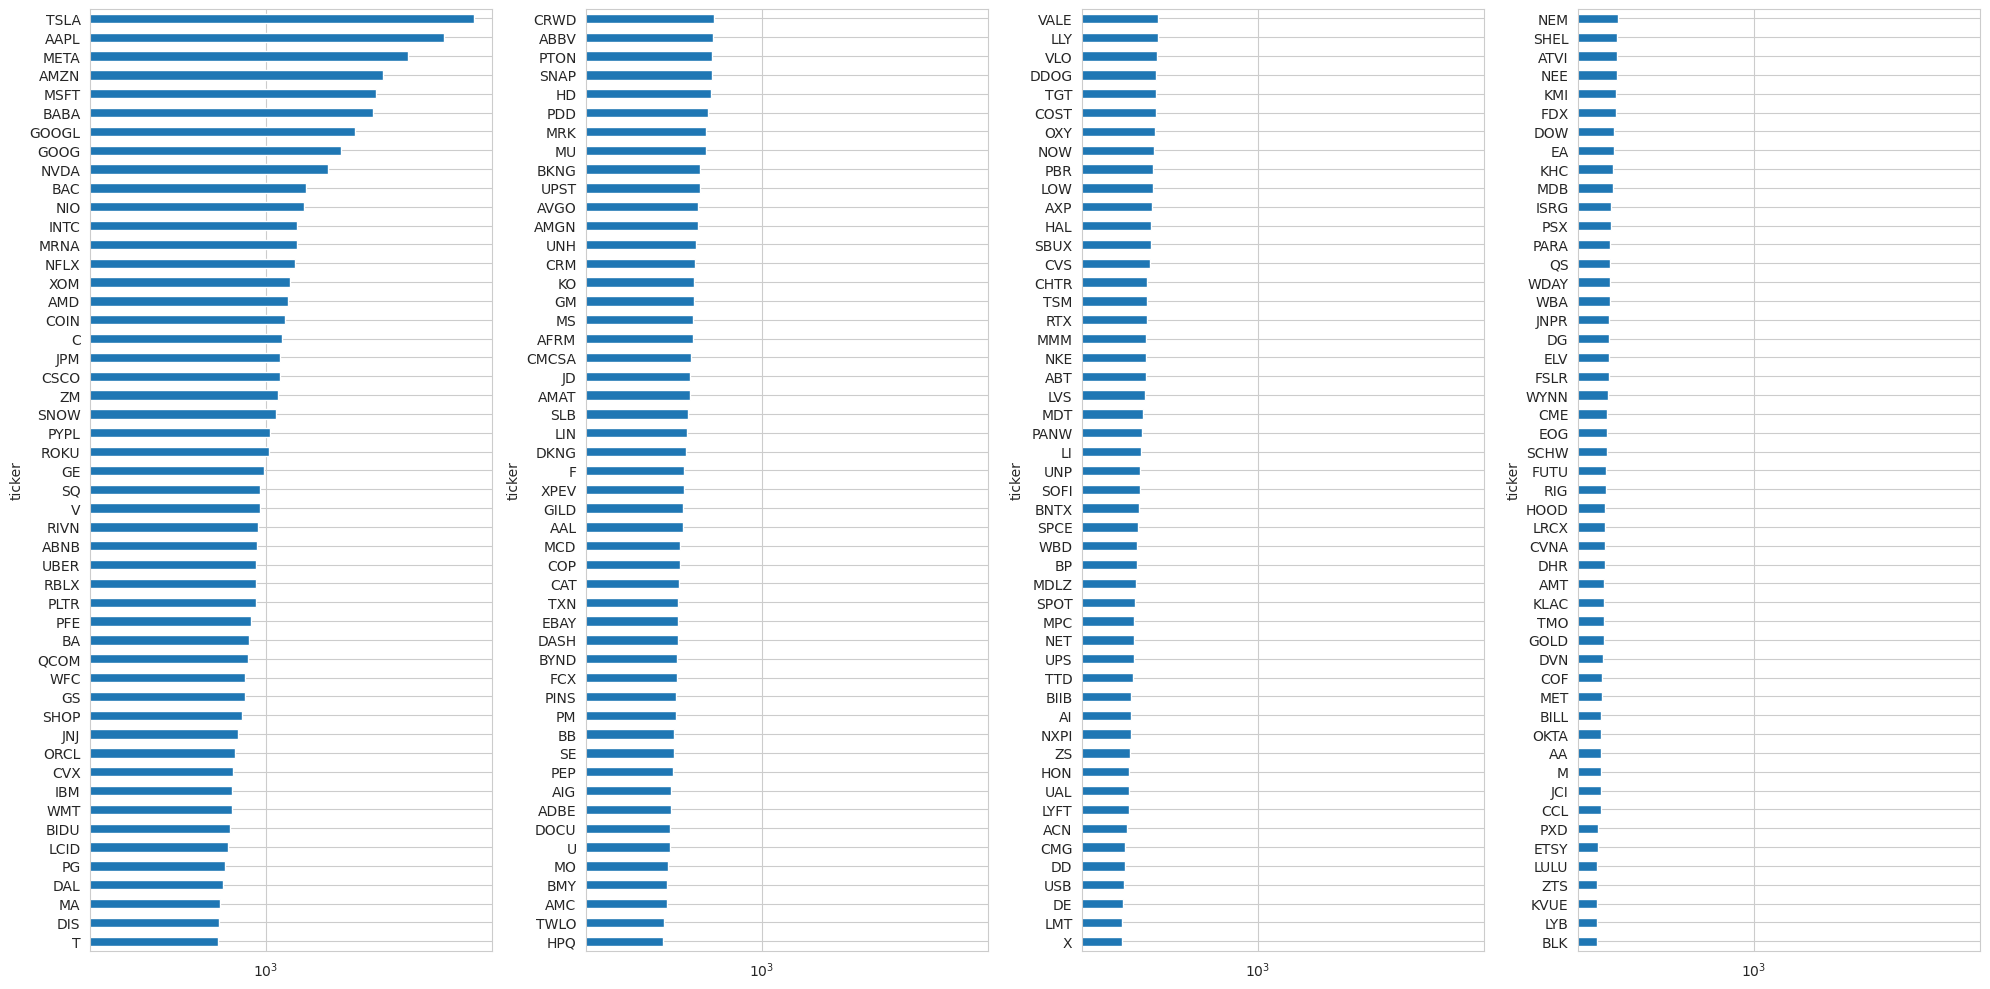

In [18]:
dv = data.close.mul(data.volume).div(1e6)  # scaling values to millions
dv = dv[~dv.index.duplicated(keep='first')]

# Group by date and ticker, then by ticker alone
avg_dv_per_ticker = dv.groupby(level=['date', 'ticker']).mean().groupby(level='ticker').mean()

# Get top 200 tickers based on the average dollar volume
top200_tickers = avg_dv_per_ticker.nlargest(200)

cutoffs = [0, 50, 100, 150, 200]
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top200_tickers.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])

fig.tight_layout()

In [19]:
to_drop = data.index.unique('ticker').difference(top500.index)

In [20]:
len(to_drop)

6200

In [21]:
data = data.drop(to_drop, level='ticker')

In [22]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2594725 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZION', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        2594725 non-null  float64
 1   high        2594725 non-null  float64
 2   low         2594725 non-null  float64
 3   close       2594725 non-null  float64
 4   volume      2594725 non-null  float64
 5   market cap  2594725 non-null  float64
 6   sector      2594725 non-null  float64
dtypes: float64(7)
memory usage: 149.0+ MB


In [23]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 5,940


##### Remove outlier observations based on daily returns

In [24]:
before = len(data)
data['ret'] = data.groupby('ticker').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

Dropped 7,799
